## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<hr>

## Loading Files

In [2]:
X = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy')
y = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')

print(X.shape, y.shape)

(20000, 6, 28) (20000,)


<hr>

## Dataset class

In [3]:
class SimpleDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx])  # shape: (6, 28)
        y = torch.tensor(self.labels[idx])
        return {"x": x, "y": y}

In [23]:
full_dataset = SimpleDataset(X, y)
full_dataloader = DataLoader(full_dataset, batch_size=64, shuffle=False)

<hr>

## Model

In [4]:
################ CNN Backbone
def conv_block(in_channels: int, out_channels: int) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
    )
 
 
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = conv_block(6, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)

        self.global_pool = nn.AdaptiveAvgPool1d((1))
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
 
        x=self.global_pool(x)

        x = x.view(x.size(0), -1)

        return x
 
 
################ Fully connected network
class FC(nn.Module):
    def __init__(self,input_dim):
        super(FC, self).__init__()
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x=self.fco(x)
        return x

In [5]:
# Loading model weights
backbone_state = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth')
fc_state = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth')

backbone_state = OrderedDict((k.replace('module.', ''), v) for k, v in backbone_state.items())
fc_state = OrderedDict((k.replace('module.', ''), v) for k, v in fc_state.items())

# Initialize and load models
backbone = cnn()
backbone.to(device)

fc = FC(1024)
fc.to(device)

backbone.load_state_dict(backbone_state)
fc.load_state_dict(fc_state)

<All keys matched successfully>

<hr>

## Evaluation Function

In [6]:
def eval_perf(dataloader, backbone, fc, device):
    backbone.eval()
    fc.eval()

    pred=[]
    gt=[]

    with torch.no_grad():
        for batch in dataloader:
            xt, yt = batch["x"].to(device), batch["y"].to(device)

            # Forward pass through backbone and FC head
            features = backbone(xt)
            outputs = fc(features)
            
            yt_pred = torch.argmax(outputs, dim=1)
            pred.extend(yt_pred.cpu().numpy())
            gt.extend(yt.cpu().numpy())

    # Convert to numpy arrays
    pred = np.array(pred)
    gt = np.array(gt)

    # Computing metrics
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    acc = np.mean(pred == gt)
    avg_f1 = f1s.mean()

    # Set models back to train mode
    backbone.train()
    fc.train()

    return f1s, acc, avg_f1

## Query Sampler

In [15]:
# Initialize pools
labeled_pool = set()
unlabeled_pool = set(range(len(X)))  # {0, 1, ..., 19999}

def query_least_confident(X, model_backbone, model_fc, k, device, unlabeled_pool):
    model_backbone.eval()
    model_fc.eval()

    X = np.array(X)  # ensure indexing works
    all_probs = []
    idx_list = sorted(list(unlabeled_pool))
    
    with torch.no_grad():
        for i in range(0, len(idx_list), 64):
            batch_indices = idx_list[i:i+64]
            batch = torch.tensor(X[batch_indices], dtype=torch.float32).to(device)
            feats = model_backbone(batch)
            out = model_fc(feats)
            probs = torch.nn.functional.softmax(out, dim=1)
            max_confidence = torch.max(probs, dim=1)[0]
            all_probs.extend(zip(batch_indices, max_confidence.cpu().numpy()))

    # Sort by lowest confidence (most uncertain)
    sorted_by_conf = sorted(all_probs, key=lambda x: x[1])
    queried = [idx for idx, conf in sorted_by_conf[:k]]

    return queried

<hr>

## Training Loop

In [31]:
history = {
    "rounds": [],
    "num_labeled": [],
    "accuracy": [],
    "avg_f1": [],
    "f1s": [],
}

In [28]:
def train(backbone, fc, train_loader, device, epochs=15):
    backbone.train()
    fc.train()

    optimizer = torch.optim.Adam(list(backbone.parameters()) + list(fc.parameters()), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            xt = batch["x"].to(device)
            yt = batch["y"].to(device)

            optimizer.zero_grad()

            features = backbone(xt)
            outputs = fc(features)
            loss = F.cross_entropy(outputs, yt)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

<hr>

## AL Pipeline Loop

In [32]:
num_rounds = 10

for round_num in range(1, num_rounds+1):
    print(f"\n--- Active Learning Round {round_num} ---")
    
    # 1. Query k samples
    queried_indices = query_least_confident(
        X=X,
        model_backbone=backbone,
        model_fc=fc,
        k=100,
        device=device,
        unlabeled_pool=unlabeled_pool
    )

    # 2. Update pools
    labeled_pool.update(queried_indices)
    unlabeled_pool.difference_update(queried_indices)
    print(f'Labeled Pool: {len(labeled_pool)}')
    print(f'Unlabeled Pool: {len(unlabeled_pool)}')

    # 3. Build train loader
    train_dataset = SimpleDataset(X[list(labeled_pool)], y[list(labeled_pool)])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # 4. Train + Evaluate
    train(backbone, fc, train_loader, device, epochs=5)
    f1s, acc, avg_f1 = eval_perf(full_dataloader, backbone, fc, device)

    print("Per-class F1 scores:", f1s)
    print(f"Overall Accuracy: {acc * 100:.2f}%")
    print(f"Average F1 Score: {avg_f1:.4f}")

    # 6. Update history
    history["rounds"].append(round_num)
    history["num_labeled"].append(len(labeled_pool))
    history["accuracy"].append(acc)
    history["avg_f1"].append(avg_f1)
    history["f1s"].append(f1s.tolist())


--- Active Learning Round 1 ---
Labeled Pool: 220
Unlabeled Pool: 19780
Epoch 1/5, Loss: 0.8425
Epoch 2/5, Loss: 0.6387
Epoch 3/5, Loss: 0.6005
Epoch 4/5, Loss: 0.3422
Epoch 5/5, Loss: 0.2636
Per-class F1 scores: [0.78364159 0.74162445 0.73063973]
Overall Accuracy: 75.67%
Average F1 Score: 0.7520

--- Active Learning Round 2 ---
Labeled Pool: 320
Unlabeled Pool: 19680
Epoch 1/5, Loss: 0.5951
Epoch 2/5, Loss: 0.4209
Epoch 3/5, Loss: 0.2984
Epoch 4/5, Loss: 0.2235
Epoch 5/5, Loss: 0.1930
Per-class F1 scores: [0.65500418 0.84539598 0.76263866]
Overall Accuracy: 73.50%
Average F1 Score: 0.7543

--- Active Learning Round 3 ---
Labeled Pool: 420
Unlabeled Pool: 19580
Epoch 1/5, Loss: 0.3736
Epoch 2/5, Loss: 0.3643
Epoch 3/5, Loss: 0.3308
Epoch 4/5, Loss: 0.3563
Epoch 5/5, Loss: 0.3470
Per-class F1 scores: [0.77611758 0.46052991 0.75905842]
Overall Accuracy: 73.87%
Average F1 Score: 0.6652

--- Active Learning Round 4 ---
Labeled Pool: 520
Unlabeled Pool: 19480
Epoch 1/5, Loss: 0.4304
Epoch 

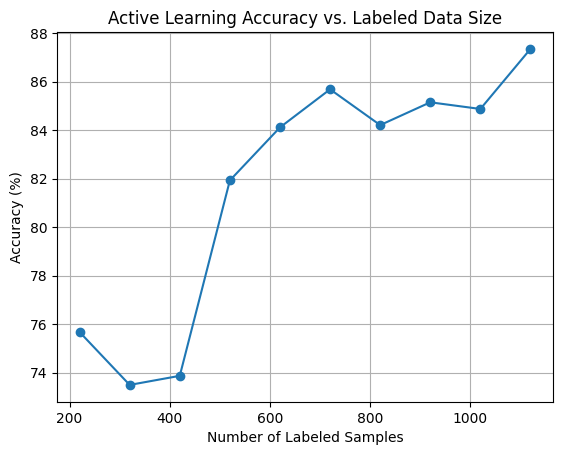

In [33]:
plt.plot(history["num_labeled"], [a * 100 for a in history["accuracy"]], marker="o")
plt.title("Active Learning Accuracy vs. Labeled Data Size")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()